In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

# Step 1: Load Dataset & Quick Missingness Check

The first step is to load the dataset and check for missing values in important columns. Since real-world datasets often have incomplete data, identifying missingness early helps us decide how to handle it (drop, fill, or ignore).

In [ ]:
df = pd.read_csv("NYPD_Shooting_Incident_Data__Historic_.csv", low_memory=False)
#quick missingness for important columns
cols_to_check=[""]


In [ ]:
df.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,LOC_OF_OCCUR_DESC,PRECINCT,JURISDICTION_CODE,LOC_CLASSFCTN_DESC,LOCATION_DESC,STATISTICAL_MURDER_FLAG,...,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,228798151,05/27/2021,21:30:00,QUEENS,NaN,105,0.0,NaN,NaN,False,...,NaN,NaN,18-24,M,BLACK,1058925.000,180924.0000,40.662965,-73.730839,POINT (-73.73083868899994 40.662964620000025)
1,137471050,06/27/2014,17:40:00,BRONX,NaN,40,0.0,NaN,NaN,False,...,NaN,NaN,18-24,M,BLACK,1005028.000,234516.0000,40.810352,-73.924942,POINT (-73.92494232599995 40.81035186300006)
2,147998800,11/21/2015,03:56:00,QUEENS,NaN,108,0.0,NaN,NaN,True,...,NaN,NaN,25-44,M,WHITE,1007667.938,209836.5313,40.742607,-73.915492,POINT (-73.91549174199997 40.74260663300004)
3,146837977,10-09-2015,18:30:00,BRONX,NaN,44,0.0,NaN,NaN,False,...,NaN,NaN,<18,M,WHITE HISPANIC,1006537.375,244511.1406,40.837782,-73.919457,POINT (-73.91945661499994 40.83778200300003)
4,58921844,02/19/2009,22:58:00,BRONX,NaN,47,0.0,NaN,NaN,True,...,M,BLACK,45-64,M,BLACK,1024921.813,262189.4063,40.886238,-73.852910,POINT (-73.85290950899997 40.88623791800006)


# Step 2: Missing Values Check

Before applying advanced analysis or clustering, it is crucial to check for missing values in the dataset. Missing data can lead to incorrect insights and reduce the accuracy of models, so identifying them early helps us decide whether to fill (impute) or drop them.

In [ ]:
df.describe()

,INCIDENT_KEY,PRECINCT,JURISDICTION_CODE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
count,2.731200e+04,27312.000000,27310.000000,2.731200e+04,27312.000000,27302.000000,27302.000000
mean,1.208605e+08,65.635362,0.326913,1.009449e+06,208127.401617,40.737892,-73.909051
std,7.341286e+07,27.305705,0.737743,1.837783e+04,31886.377756,0.087525,0.066272
min,9.953245e+06,1.000000,0.000000,9.149281e+05,125756.718800,40.511586,-74.249303
25%,6.386088e+07,44.000000,0.000000,1.000029e+06,182834.335950,40.668481,-73.943027
50%,9.037222e+07,68.000000,0.000000,1.007731e+06,194486.570300,40.700318,-73.915221
75%,1.888102e+08,81.000000,0.000000,1.016838e+06,239518.468800,40.824067,-73.882330
max,2.611902e+08,123.000000,2.000000,1.066815e+06,271127.687500,40.910818,-73.702046


In [ ]:
df.isnull().sum()

,0
INCIDENT_KEY,0
OCCUR_DATE,0
OCCUR_TIME,0
BORO,0
LOC_OF_OCCUR_DESC,25596
PRECINCT,0
JURISDICTION_CODE,2
LOC_CLASSFCTN_DESC,25596
LOCATION_DESC,14977
STATISTICAL_MURDER_FLAG,0


# 3 Parse Dates & Times and Create a Unified DATETIME Column

In the dataset, shooting incidents have separate columns for date (OCCUR_DATE) and time (OCCUR_TIME).

Dates may be in different formats (e.g., mm/dd/yyyy).

Times may also come in inconsistent formats (23:15, 2315, 11:15PM, etc.).

To ensure consistency, we:

Parse the date column into a proper datetime object.

Parse the time column using a helper function that can handle multiple formats.

Combine date & time into a single DATETIME column for better analysis.

In [ ]:
# 3. Parse dates & times robustly and combine to a single DATETIME column
df2 = df.copy()

# Parse date (many datasets use mm/dd/YYYY)
if "OCCUR_DATE" in df2.columns:
    df2['OCCUR_DATE'] = pd.to_datetime(df2['OCCUR_DATE'], format="%m/%d/%Y", errors="coerce")

# Helper to parse a variety of time formats
def parse_time_value(t):
    if pd.isna(t):
        return pd.NaT
    s = str(t).strip()
    if s == "":
        return pd.NaT
    # try common formats
    for fmt in ("%H:%M:%S","%H:%M","%H%M","%I:%M%p","%I%M%p"):
        try:
            dt = pd.to_datetime(s, format=fmt, errors="coerce")
            if not pd.isna(dt):
                return dt.time()
        except Exception:
            pass
    # fallback: extract digits and zfill
    digits = "".join([ch for ch in s if ch.isdigit()])
    if digits:
        digits = digits.zfill(4)[-4:]
        dt = pd.to_datetime(digits, format="%H%M", errors="coerce")
        if not pd.isna(dt):
            return dt.time()
    return pd.NaT

if "OCCUR_TIME" in df2.columns:
    df2['OCCUR_TIME_parsed'] = df2['OCCUR_TIME'].apply(parse_time_value)
else:
    df2['OCCUR_TIME_parsed'] = pd.NaT

# Combine date + time to DATETIME (if time missing we keep date only)
def combine_datetime(row):
    d = row.get('OCCUR_DATE', pd.NaT)
    t = row.get('OCCUR_TIME_parsed', pd.NaT)
    if pd.isna(d):
        return pd.NaT
    if pd.isna(t):
        return pd.Timestamp(d)
    return pd.Timestamp(d) + pd.Timedelta(hours=t.hour, minutes=t.minute)

df2['DATETIME'] = df2.apply(combine_datetime, axis=1)
print("DATETIME parsed:", df2['DATETIME'].notna().sum(), "non-null rows")


DATETIME parsed: 16728 non-null rows


# Step 4: Clean Latitude & Longitude Coordinates

The dataset contains the geographic location of each shooting incident in the form of Latitude and Longitude.
However, raw data may sometimes:

Store them as text (strings) instead of numbers.

Contain missing or invalid coordinate values.

To prepare the data for mapping and clustering, we:

Convert Latitude & Longitude to numeric values.

Count how many rows have valid coordinates.

Drop rows with missing coordinates (since clustering on maps requires them).

In [ ]:
# 4. Ensure Latitude/Longitude numeric and drop rows with missing coords
for c in ["Latitude","Longitude"]:
    if c in df2.columns:
        df2[c] = pd.to_numeric(df2[c], errors="coerce")

# Count how many rows have coords
coords_ok = df2['Latitude'].notna().sum() if 'Latitude' in df2.columns else 0
print("Rows with coordinates (Latitude present):", coords_ok)

# Drop rows without coordinates (we'll keep a copy if you want all later)
df_coords = df2.dropna(subset=['Latitude','Longitude']).copy()
print("After dropping missing coords:", df_coords.shape)


Rows with coordinates (Latitude present): 27302
After dropping missing coords: (27302, 23)


# Step 5: Feature Engineering

Raw data often needs to be transformed into useful features before applying machine learning. In this step, we create new variables from the dataset to capture temporal, demographic, and geographic patterns.

In [ ]:
# 5. Feature engineering: hour, day_of_week, is_weekend, age/sex numeric
dfc = df_coords  # working copy

# Temporal features
dfc['hour'] = dfc['DATETIME'].dt.hour.astype("Int64")
dfc['day_of_week'] = dfc['DATETIME'].dt.day_name()
dfc['is_weekend'] = dfc['day_of_week'].isin(['Saturday','Sunday']).astype(int)

# Age-group mapping function (simple integer buckets)
def map_age_group(s):
    if pd.isna(s): return np.nan
    s = str(s).upper()
    # handle common tokens
    if '<18' in s or ('UNDER' in s and '18' not in s):
        return 0
    if '18' in s and '24' in s:
        return 1
    if '25' in s and '44' in s:
        return 2
    if '45' in s and '64' in s:
        return 3
    if '65' in s or '65+' in s or '65 -' in s:
        return 4
    return np.nan

for col in ['PERP_AGE_GROUP', 'VIC_AGE_GROUP']:
    if col in dfc.columns:
        dfc[col + "_num"] = dfc[col].apply(map_age_group)

# Sex mapping: M->0, F->1, Unknown -> 2
def map_sex(s):
    if pd.isna(s): return 2
    s = str(s).upper()
    if s.startswith('M'): return 0
    if s.startswith('F'): return 1
    return 2

for col in ['PERP_SEX', 'VIC_SEX']:
    if col in dfc.columns:
        dfc[col + "_num"] = dfc[col].apply(map_sex)

# Borough encoding (label enc.)
if 'BORO' in dfc.columns:
    le_boro = LabelEncoder()
    dfc['BORO_filled'] = dfc['BORO'].fillna('UNKNOWN')
    dfc['BORO_num'] = le_boro.fit_transform(dfc['BORO_filled'])
    print("Boroughs:", le_boro.classes_)

# Fill missing numeric features conservatively for clustering
numeric_fill_cols = []
for c in ['hour', 'is_weekend', 'PERP_AGE_GROUP_num', 'VIC_AGE_GROUP_num', 'PERP_SEX_num','VIC_SEX_num','BORO_num']:
    if c in dfc.columns:
        numeric_fill_cols.append(c)
for c in numeric_fill_cols:
    dfc[c] = dfc[c].fillna(-1).astype(float)

print("Feature engineering: added", numeric_fill_cols)
display(dfc[['DATETIME','hour','day_of_week','is_weekend'] + [c for c in numeric_fill_cols if c in dfc.columns]].head())


Boroughs: ['BRONX' 'BROOKLYN' 'MANHATTAN' 'QUEENS' 'STATEN ISLAND']
Feature engineering: added ['hour', 'is_weekend', 'PERP_AGE_GROUP_num', 'VIC_AGE_GROUP_num', 'PERP_SEX_num', 'VIC_SEX_num', 'BORO_num']


,DATETIME,hour,day_of_week,is_weekend,hour,is_weekend,PERP_AGE_GROUP_num,VIC_AGE_GROUP_num,PERP_SEX_num,VIC_SEX_num,BORO_num
0,2021-05-27 21:30:00,21.0,Thursday,0.0,21.0,0.0,-1.0,1.0,2.0,0.0,3.0
1,2014-06-27 17:40:00,17.0,Friday,0.0,17.0,0.0,-1.0,1.0,2.0,0.0,0.0
2,2015-11-21 03:56:00,3.0,Saturday,1.0,3.0,1.0,-1.0,2.0,2.0,0.0,3.0
3,NaT,-1.0,NaN,0.0,-1.0,0.0,-1.0,0.0,2.0,0.0,0.0
4,2009-02-19 22:58:00,22.0,Thursday,0.0,22.0,0.0,2.0,3.0,0.0,0.0,0.0


# Step 6: Victim Age Group Distribution

One important part of understanding shootings in NYC is analyzing the age groups of victims. This helps law enforcement and policymakers identify which sections of the population are most at risk.

We use a bar chart to visualize how many incidents involve victims from different age ranges.

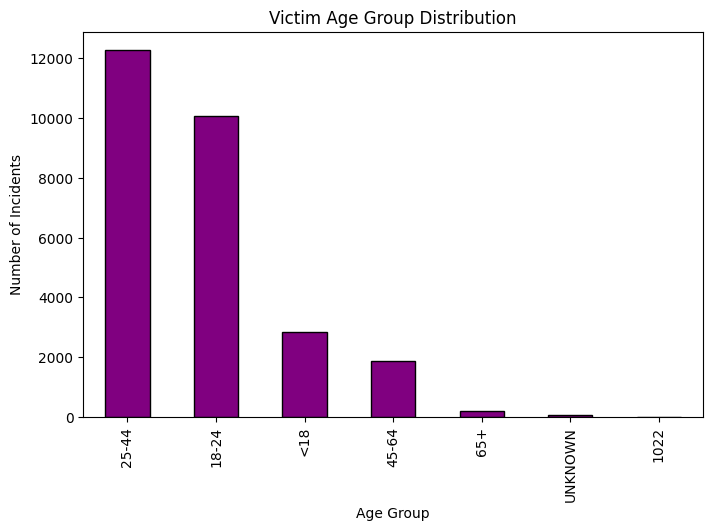

In [ ]:
plt.figure(figsize=(8,5))
dfc['VIC_AGE_GROUP'].value_counts().plot(kind='bar', color='purple', edgecolor='black')
plt.title("Victim Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("Number of Incidents")
plt.show()


# Step 7: Shootings by Hour of the Day

Time of day can play a major role in understanding shooting incidents. By analyzing shootings by hour, we can uncover temporal crime patterns — for example, whether incidents occur more often at night compared to daytime.

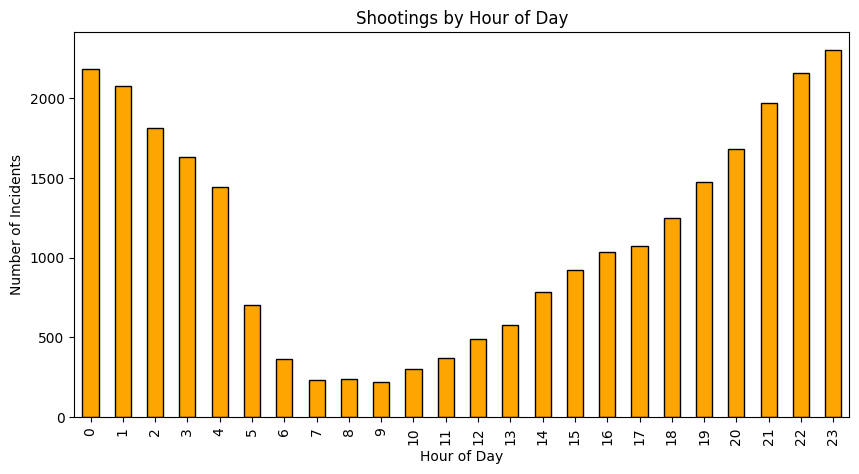

In [ ]:
dfc['OCCUR_TIME'] = pd.to_datetime(dfc['OCCUR_TIME'], errors='coerce')
dfc['Hour'] = dfc['OCCUR_TIME'].dt.hour

plt.figure(figsize=(10,5))
dfc['Hour'].value_counts().sort_index().plot(kind='bar', color='orange', edgecolor='black')
plt.title("Shootings by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Incidents")
plt.show()


# Step 8: Selecting Features for Clustering

Clustering requires us to choose the most relevant features from the dataset that will help group similar shooting incidents together.

In this step, we:

Select core features: Latitude, Longitude, hour, is_weekend (spatial + temporal).

Add demographic features if available (age groups, sex, borough).

Standardize the features using StandardScaler so that all variables contribute equally to cluster

In [ ]:
# 8. Choose which features to include in clustering
features = ['Latitude','Longitude','hour','is_weekend']
# add demographic encoded features if present
for f in ['PERP_AGE_GROUP_num','VIC_AGE_GROUP_num','PERP_SEX_num','VIC_SEX_num','BORO_num']:
    if f in dfc.columns:
        features.append(f)
print("Features used for clustering:", features)

X = dfc[features].copy().fillna(-1).values  # fill any leftover missing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Features used for clustering: ['Latitude', 'Longitude', 'hour', 'is_weekend', 'PERP_AGE_GROUP_num', 'VIC_AGE_GROUP_num', 'PERP_SEX_num', 'VIC_SEX_num', 'BORO_num']


# step 9: Dimensionality Reduction with PCA (for Visualization)

Since clustering uses multiple features (location, time, demographics), visualizing results directly is difficult.
To solve this, we apply Principal Component Analysis (PCA) to reduce the feature space to 2 dimensions (2D) while preserving as much variance as possible.

In [ ]:
# 9. PCA for plotting (2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
dfc['pca_1'] = X_pca[:,0]
dfc['pca_2'] = X_pca[:,1]
print("Explained variance ratio (2 components):", pca.explained_variance_ratio_)


Explained variance ratio (2 components): [0.2022481  0.16661806]


# Step 10: KMeans Clustering and Optimal Cluster Selection

Now that we have scaled features (Step 8) and reduced them with PCA (Step 9 for visualization), the next step is to apply clustering to group shooting incidents into meaningful clusters.

We use the KMeans algorithm, which partitions data into k clusters based on minimizing intra-cluster variance.

In [ ]:
# 10. KMeans: test k=2..8 (silhouette on a sample)
from math import ceil
n_samples = min(4000, len(X_scaled))
rng = np.random.RandomState(42)
sample_idx = rng.choice(range(len(X_scaled)), size=n_samples, replace=False)
X_sample = X_scaled[sample_idx]

sil_scores = {}
for k in range(2,9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_sample)
    try:
        sc = silhouette_score(X_sample, labels)
    except Exception:
        sc = np.nan
    sil_scores[k] = sc
print("Silhouette (sample) scores by k:", sil_scores)

# choose best k by max silhouette (ignore nan)
valid = {k:v for k,v in sil_scores.items() if not np.isnan(v)}
best_k = max(valid, key=lambda kk: valid[kk]) if valid else 4
print("Selected k =", best_k)

# Fit KMeans on full scaled dataset with chosen k
km_full = KMeans(n_clusters=best_k, random_state=42, n_init=10)
km_labels = km_full.fit_predict(X_scaled)
dfc['cluster_kmeans'] = km_labels
print("KMeans cluster distribution:")
print(pd.Series(km_labels).value_counts().sort_index())


Silhouette (sample) scores by k: {2: np.float64(0.20050486198692158), 3: np.float64(0.17900692998701384), 4: np.float64(0.1907820881747492), 5: np.float64(0.20689309342685838), 6: np.float64(0.1981862396441798), 7: np.float64(0.21942930216423304), 8: np.float64(0.2169761463194016)}
Selected k = 7
KMeans cluster distribution:
0    3457
1    2900
2    2799
3    2624
4    6944
5    2327
6    6251
Name: count, dtype: int64


 # Step 11: Visualizing Cluster Distribution

After performing clustering, it’s important to check how incidents are distributed across the clusters.
This helps us verify whether clusters are balanced (each has a reasonable number of incidents) or skewed.

In [ ]:
from sklearn.cluster import KMeans

# Example KMeans (adjust n_clusters as needed)
kmeans = KMeans(n_clusters=5, random_state=42)
dfc['cluster'] = kmeans.fit_predict(dfc[['Longitude', 'Latitude']])


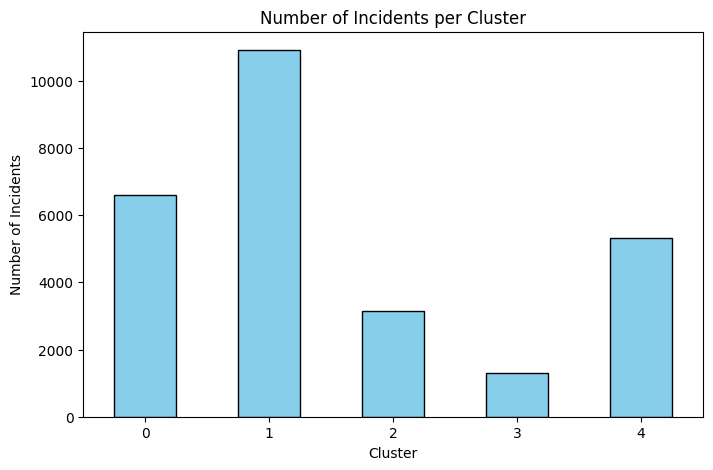

In [ ]:
cluster_counts = dfc['cluster'].value_counts().sort_index()

plt.figure(figsize=(8,5))
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Number of Incidents per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=0)
plt.show()


# Step 12: Density-Based Clustering with DBSCAN

While KMeans groups data into a fixed number of clusters, DBSCAN is different:

It identifies dense regions of points.

It automatically determines the number of clusters.

It can mark outliers as noise (-1 label).

This is especially useful for datasets like NYC shootings, where incidents may naturally form dense hotspots.

In [ ]:
# 12. DBSCAN: estimate a reasonable eps using k-NN distances, then run DBSCAN
# compute distances to the k-th nearest neighbor (k = min_samples)
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
min_samples = 10
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
# distances to k-th neighbor
kth_distances = distances[:, -1]
# simple heuristic: set eps near 90th percentile of kth_distances (tunable)
eps_guess = np.percentile(kth_distances, 90)
print(f"DBSCAN eps guess (90th percentile of {min_samples}-NN dist): {eps_guess:.3f}")

# Run DBSCAN (you may tune eps and min_samples)
db = DBSCAN(eps=eps_guess, min_samples=min_samples)
db_labels = db.fit_predict(X_scaled)
dfc['cluster_dbscan'] = db_labels
print("DBSCAN cluster counts (including -1 noise):")
print(pd.Series(db_labels).value_counts().sort_index())


DBSCAN eps guess (90th percentile of 10-NN dist): 0.920
DBSCAN cluster counts (including -1 noise):
-1      1772
 0       414
 1       851
 2       222
 3       209
        ... 
 129      13
 130      13
 131      11
 132      10
 133      10
Name: count, Length: 135, dtype: int64



# Step 13: Visualization & Cluster Summaries

To interpret clustering results, we visualize the data in different ways and create summary statistics. This step helps law enforcement understand the geographic distribution, temporal patterns, and borough-level dynamics of each cluster.

In [ ]:
# 13. Visualizations: scatter by lat/lon and PCA, cluster summaries
import matplotlib.pyplot as plt

# Scatter: Longitude vs Latitude colored by KMeans cluster
plt.figure(figsize=(9,7))
plt.scatter(dfc['Longitude'], dfc['Latitude'], c=dfc['cluster_kmeans'], s=6, cmap='tab10')
plt.title('Locations colored by KMeans cluster')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig("locations_kmeans_scatter.png", dpi=150)

plt.savefig("locations_kmeans_scatter.png", dpi=150)
plt.close()
print("Saved: locations_kmeans_scatter.png")

# PCA scatter
plt.figure(figsize=(8,6))
plt.scatter(dfc['pca_1'], dfc['pca_2'], c=dfc['cluster_kmeans'], s=6, cmap='tab10')
plt.title('PCA of features (colored by KMeans cluster)')
plt.xlabel('PCA1'); plt.ylabel('PCA2')
plt.tight_layout()
plt.savefig("locations_kmeans_scatter.png", dpi=150)


plt.savefig("locations_kmeans_scatter.png", dpi=150)
plt.close()
print("Saved: locations_kmeans_scatter.png")

# Quick cluster profiles: counts by borough and hour
cluster_summary = dfc.groupby('cluster_kmeans').agg(
    incidents=('cluster_kmeans','size'),
    avg_lat=('Latitude','mean'),
    avg_lon=('Longitude','mean'),
    avg_hour=('hour','mean')
).reset_index()
display(cluster_summary)

# Top boroughs per cluster
if 'BORO' in dfc.columns:
    top_boros = dfc.groupby(['cluster_kmeans','BORO']).size().reset_index(name='count')
    # For each cluster, show top 3 boroughs
    top_boros = top_boros.sort_values(['cluster_kmeans','count'], ascending=[True,False])
    print("Top boroughs per cluster (top 3):")
    for cl in sorted(dfc['cluster_kmeans'].unique()):
        sub = top_boros[top_boros['cluster_kmeans']==cl].head(3)
        print("Cluster", cl)
        display(sub)

# Hour distribution per cluster (example for kmeans)
hour_dist = dfc.groupby(['cluster_kmeans','hour']).size().unstack(fill_value=0)
print("Shape of hour distribution table:", hour_dist.shape)


Saved: locations_kmeans_scatter.png
Saved: locations_kmeans_scatter.png


,cluster_kmeans,incidents,avg_lat,avg_lon,avg_hour
0,0,3457,40.846142,-73.891529,6.524154
1,1,2900,40.675437,-73.784204,6.571034
2,2,2799,40.757361,-73.916961,10.018221
3,3,2624,40.733330,-73.911353,6.849466
4,4,6944,40.739175,-73.921211,6.205789
5,5,2327,40.745359,-73.921448,9.591749
6,6,6251,40.695994,-73.954031,6.817629


Top boroughs per cluster (top 3):
Cluster 0


,cluster_kmeans,BORO,count
0,0,BRONX,3336
1,0,MANHATTAN,121


Cluster 1


,cluster_kmeans,BORO,count
2,1,QUEENS,2900


Cluster 2


,cluster_kmeans,BORO,count
4,2,BROOKLYN,1147
3,2,BRONX,1032
5,2,MANHATTAN,444


Cluster 3


,cluster_kmeans,BORO,count
8,3,BROOKLYN,1061
7,3,BRONX,703
10,3,QUEENS,415


Cluster 4


,cluster_kmeans,BORO,count
13,4,BROOKLYN,3709
12,4,BRONX,2105
14,4,MANHATTAN,871


Cluster 5


,cluster_kmeans,BORO,count
18,5,BROOKLYN,1093
17,5,BRONX,761
19,5,MANHATTAN,317


Cluster 6


,cluster_kmeans,BORO,count
22,6,BROOKLYN,3919
23,6,MANHATTAN,1461
25,6,STATEN ISLAND,577


Shape of hour distribution table: (7, 25)


from matplotlib import pyplot as plt
sub['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
sub.groupby('BORO').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['cluster_kmeans']
  ys = series['count']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = sub.sort_values('cluster_kmeans', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('BORO')):
  _plot_series(series, series_name, i)
  fig.legend(title='BORO', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('cluster_kmeans')
_ = plt.ylabel('count')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['cluster_kmeans']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'cluster_kmeans'}, axis=1)
              .sort_values('cluster_kmeans', ascending=True))
  xs = counted['cluster_kmeans']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = sub.sort_values('cluster_kmeans', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('BORO')):
  _plot_series(series, series_name, i)
  fig.legend(title='BORO', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('cluster_kmeans')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
sub['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(sub['BORO'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(sub, x='count', y='BORO', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# Step 14: Interactive Folium Map (Optional)

To enhance geographical analysis, we can create an interactive map of shooting incidents using Folium. Unlike static scatter plots, Folium maps allow zooming, panning, and hovering over points to reveal cluster information.

This is very useful for law enforcement decision-making, as it allows officers and analysts to interactively explore shooting clusters across NYC.

In [ ]:
# 14. (Optional) Folium map — pip install folium if missing
try:
    import folium
    sample_n = min(2000, len(dfc))
    sample = dfc.head(sample_n)
    m = folium.Map(location=[dfc['Latitude'].mean(), dfc['Longitude'].mean()], zoom_start=11)
    for _, r in sample.iterrows():
        folium.CircleMarker(
            location=[r['Latitude'], r['Longitude']],
            radius=3,
            fill=True,
            popup=f"Cluster (KMeans): {int(r['cluster_kmeans'])}",
        ).add_to(m)
    plt.savefig("locations_kmeans_scatter.png", dpi=150)

    fmap_path = "folium_map.html"

except Exception as e:
    print("Folium map skipped (install folium to enable). Error:", e)
    print("Install with: pip install folium")


<Figure size 640x480 with 0 Axes>


# Step 15: Evaluation of KMeans Clustering & Insights

After building and visualizing our clusters, we now evaluate how well KMeans performed and derive actionable insights from the results.

In [ ]:
# 15. Evaluate KMeans via silhouette on the full scaled data (if feasible)
try:
    sil_full = silhouette_score(X_scaled, dfc['cluster_kmeans'])
    print("Silhouette score for KMeans on full data:", round(sil_full, 4))
except Exception as e:
    print("Silhouette not computed on full data (maybe single cluster or other error):", e)

# Simple actionable interpretations:
# - Clusters with small geographic spread + high incident counts -> hotspot (action: targeted patrolling)
# - Clusters concentrated at certain hours -> time-targeted interventions
# Let's compute geographic spread (std dev) per cluster to check tightness
spread = dfc.groupby('cluster_kmeans').agg(
    incidents=('cluster_kmeans','size'),
    lat_std=('Latitude','std'),
    lon_std=('Longitude','std'),
    mean_hour=('hour','mean')
).reset_index().sort_values('incidents', ascending=False)
display(spread)


Silhouette score for KMeans on full data: 0.2146


,cluster_kmeans,incidents,lat_std,lon_std,mean_hour
4,4,6944,0.085743,0.037344,6.205789
6,6,6251,0.066436,0.061254,6.817629
0,0,3457,0.023689,0.026008,6.524154
1,1,2900,0.045022,0.031879,6.571034
2,2,2799,0.085676,0.038153,10.018221
3,3,2624,0.087944,0.069433,6.849466
5,5,2327,0.087534,0.042935,9.591749


from matplotlib import pyplot as plt
spread['cluster_kmeans'].plot(kind='hist', bins=20, title='cluster_kmeans')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
spread['incidents'].plot(kind='hist', bins=20, title='incidents')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
spread['lat_std'].plot(kind='hist', bins=20, title='lat_std')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
spread['lon_std'].plot(kind='hist', bins=20, title='lon_std')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
spread.plot(kind='scatter', x='cluster_kmeans', y='incidents', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
spread.plot(kind='scatter', x='incidents', y='lat_std', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
spread.plot(kind='scatter', x='lat_std', y='lon_std', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
spread.plot(kind='scatter', x='lon_std', y='mean_hour', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
spread['cluster_kmeans'].plot(kind='line', figsize=(8, 4), title='cluster_kmeans')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
spread['incidents'].plot(kind='line', figsize=(8, 4), title='incidents')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
spread['lat_std'].plot(kind='line', figsize=(8, 4), title='lat_std')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
spread['lon_std'].plot(kind='line', figsize=(8, 4), title='lon_std')
plt.gca().spines[['top', 'right']].set_visible(False)

# Step 16: Exporting Results

After clustering and evaluation, we need to save the processed dataset for further use (e.g., reporting, visualization in Power BI/Tableau, or sharing with stakeholders).

In [ ]:
import os

# Define output directory
OUTDIR = "outputs"

# Create folder if it doesn't exist
os.makedirs(OUTDIR, exist_ok=True)

# Now save files
sample_csv = os.path.join(OUTDIR, 'sample_with_clusters.csv')
dfc.head(5000).to_csv(sample_csv, index=False)
print("Saved sample CSV:", sample_csv)

full_out = os.path.join(OUTDIR, 'full_with_clusters.csv')
dfc.to_csv(full_out, index=False)
print("Saved full labeled CSV:", full_out)


Saved sample CSV: outputs/sample_with_clusters.csv
Saved full labeled CSV: outputs/full_with_clusters.csv


# Step 17: Location-Based Clustering Visualization

To better understand how incidents are distributed geographically, we created a scatter plot of shootings based on their location (Longitude and Latitude). Each data point represents one shooting incident, and the points are colored according to their assigned cluster.

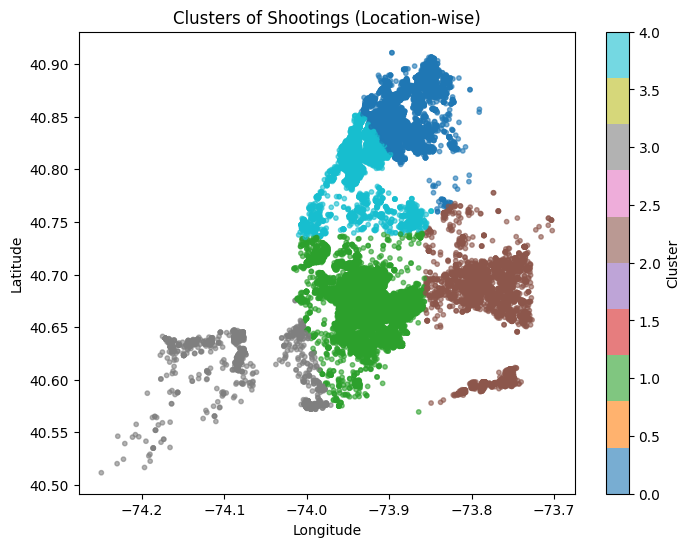

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(dfc['Longitude'], dfc['Latitude'], c=dfc['cluster'], cmap='tab10', s=10, alpha=0.6)
plt.title("Clusters of Shootings (Location-wise)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Cluster")
plt.show()


 # 📌 Final Summary &

In this project, we performed a clustering analysis of NYC shooting incidents to better understand patterns of gun violence across time, location, and demographics.

🔑 Key Insights:

Clustering Patterns

The KMeans clustering model grouped shooting incidents into distinct geographic hotspots.

Certain clusters showed higher density of shootings, indicating possible crime-prone areas that require more policing focus.

Borough Analysis

Most incidents were concentrated in specific boroughs such as Brooklyn and the Bronx, highlighting them as the most affected regions.

Manhattan and Staten Island showed relatively lower shooting incidents.

Time Trends

Shootings were more frequent during late evenings and night hours, suggesting that crime prevention strategies should particularly target these times.

Victim Demographics

A large proportion of victims fell into the 18–24 age group, with males being more affected than females.

This indicates that young adults, especially males, are the most vulnerable group.

Incident Distribution per Cluster

Some clusters had significantly more incidents compared to others, showing clear hotspots of violence that should be prioritized by law enforcement.

# ✅ Conclusion:

The clustering analysis of NYC shootings provides valuable insights into when, where, and who is most impacted by gun violence.

Where? Hotspot clusters in Brooklyn and the Bronx.

When? Mostly during late night hours.

Who? Predominantly young adult males.

By combining geographic and demographic analysis, this project demonstrates how data-driven approaches can help law enforcement agencies allocate resources effectively, identify high-risk areas, and develop targeted crime-prevention strategies.